# PUMS data for the state of Alabama

Our goals for this blog post is to:
1. Train a machine learning algorithm to predict whether someone is currently employed, based on their other attributes not including race.
2. Perform a bias audit of our algorithm to determine whether it displays racial bias.

There are approximately 48,000 rows of PUMS data in this data frame. Each one corresponds to an individual citizen of the state of Alabama who filled out the 2018 edition of the PUMS survey. We will filter through this dataset to predict employment status on the basis of demographics excluding race, and audit for racial bias. We will fit the training data on the Decision Tree Classifier model from scikit-learn and perform cross-validation to select the best max depth to achieve the highest accuracy. 

In [1]:
from folktables import ACSDataSource, ACSEmployment, BasicProblem, adult_filter
import numpy as np

STATE = "AL"

data_source = ACSDataSource(survey_year='2018', 
                            horizon='1-Year', 
                            survey='person')

acs_data = data_source.get_data(states=[STATE], download=True)

acs_data.head()

,RT,SERIALNO,DIVISION,SPORDER,PUMA,REGION,ST,ADJINC,PWGTP,AGEP,...,PWGTP71,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80
0,P,2018GQ0000049,6,1,1600,3,1,1013097,75,19,...,140,74,73,7,76,75,80,74,7,72
1,P,2018GQ0000058,6,1,1900,3,1,1013097,75,18,...,76,78,7,76,80,78,7,147,150,75
2,P,2018GQ0000219,6,1,2000,3,1,1013097,118,53,...,117,121,123,205,208,218,120,19,123,18
3,P,2018GQ0000246,6,1,2400,3,1,1013097,43,28,...,43,76,79,77,80,44,46,82,81,8
4,P,2018GQ0000251,6,1,2701,3,1,1013097,16,25,...,4,2,29,17,15,28,17,30,15,1


## Narrowing the features

We’ll focus on a relatively small number of features in the modeling tasks of this blog post. Here are all the possible features we will use:

In [2]:
possible_features=['AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P', 'ESR']
acs_data[possible_features].head()

,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RAC1P,ESR
0,19,18.0,5,17,2,NaN,1,3.0,4.0,1,1,2,2,2.0,2,1,6.0
1,18,18.0,5,17,2,NaN,1,3.0,4.0,1,1,2,2,2.0,2,2,6.0
2,53,17.0,5,16,1,NaN,1,1.0,4.0,2,1,2,2,1.0,1,1,6.0
3,28,19.0,5,16,2,NaN,1,1.0,2.0,1,1,2,2,2.0,1,1,6.0
4,25,12.0,5,16,1,NaN,1,3.0,4.0,1,1,2,2,1.0,2,1,6.0


In [27]:
features_to_use = [f for f in possible_features if f not in ["ESR", "RAC1P"]]

EmploymentProblem = BasicProblem(
    features=features_to_use,
    target='ESR',
    target_transform=lambda x: x == 1,
    group='RAC1P',
    preprocess=lambda x: x,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

features, label, group = EmploymentProblem.df_to_numpy(acs_data)

We will go ahead and split our testing and training data.

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

# Data Inspection 

Before we get into modeling, we will do some simple descriptive analysis and dissect our data for intersectional trends.

In [34]:
import pandas as pd
import numpy as np

df = pd.DataFrame(X_train, columns = features_to_use)
df["group"] = group_train
df["label"] = y_train

print(f"Number of individuals: {group_train.size}")
print(f"Percent of employed individuals: {y_train.mean()}")

df.groupby('group')[['label']].aggregate([np.mean, len]).round(2) 

Number of individuals: 38221
Percent of employed individuals: 0.4091468041129222


label       
       mean    len
group             
1      0.42  28441
2      0.37   8070
3      0.44    156
4      1.00      1
5      0.21     29
6      0.50    452
7      0.27     11
8      0.37    398
9      0.29    663

Of the 38,221 people in our training data, 40.95% have their target label equals to 1 - corresponding to those that are employed. Of the ones who are employed, 28,441 are white individuals and 8,070 are black individuals. This correspond to 42% of the white group being employed and 37% for the black group.

## Intersectional trends

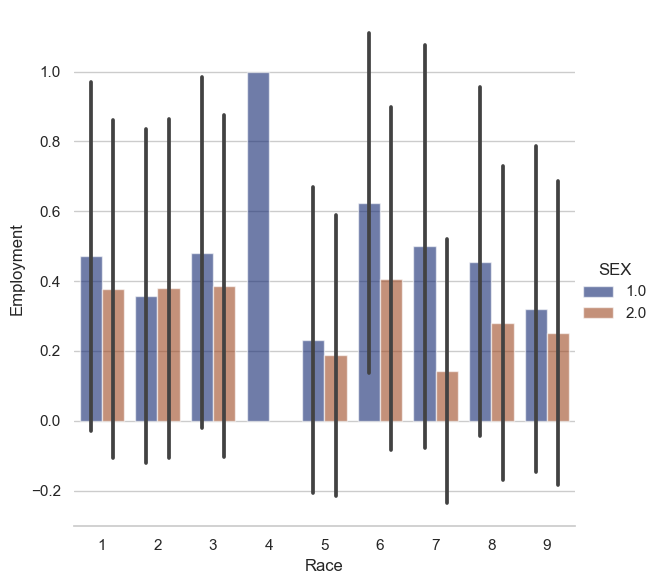

In [47]:
import seaborn as sns

sns.set_theme(style="whitegrid")

g = sns.catplot(
    data=df, kind="bar",
    x="group", y="label", hue = "SEX",
    errorbar="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("Race", "Employment")
g.savefig("image.jpg")

The chart above displays the intersectional trend between race and sex when checking for those who are employed.Men are displayed using the blue bars, and women are shown with the red bars. Overall, men have a higher employment rate across different races. But we will check to see how many women and men were accounted for in this dataset.

In [43]:
df.groupby('SEX')[['label']].aggregate([np.mean, len]).round(2)

label       
     mean    len
SEX             
1.0  0.45  18369
2.0  0.37  19852

We can see that 18,369 men and 19,852 women were accounted for in the data. Yet, men have a much higher employment rate as compared to women. 45% of men are employed and only 37% of women are employed. These differences were also seen through our intersectional Race x Gender chart above. 

# Training our data on Decision Tree Classifier

We will train our model on the training data with the Decision Tree Classifier from scikit-learn. Additionally, we will perform cross validation to tune the max depth of the algorithm. 

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

best_score_DT = 0       #keeping track of highest accuracy
max_depth = 5           #iterator

# train on decision tree classifier
while max_depth != 0:
    DT = make_pipeline(StandardScaler(), DecisionTreeClassifier(max_depth=max_depth))
    DT.fit(X_train, y_train)
    cv_scores = cross_val_score(DT, X_train, y_train, cv=5)
    mean_score = cv_scores.mean()
    print(f"Max depth = {max_depth}, score = {mean_score.round(3)}")

    # keeping the list of columns for the max_depth that has the best score 
    if (DT.score(X_train, y_train) > best_score_DT):
        best_score_DT = DT.score(X_train, y_train)
        best_DT = DT
        best_max_depth = max_depth
    
    max_depth += -1

Max depth = 5, score = 0.814
Max depth = 4, score = 0.809
Max depth = 3, score = 0.794
Max depth = 2, score = 0.767
Max depth = 1, score = 0.636


In [10]:
print(f"Best max depth: {best_max_depth}")
print(f"Best score: {best_score_DT}")

Best max depth: 5
Best score: 0.8143429004997252


# Auditting for Bias

We will go ahead and audit for racial bias.

## Overall Measures

In [11]:
y_hat = best_DT.predict(X_test)

print("The overall accuracy in predicting whether someone is employed is: ")
print((y_hat == y_test).mean())

The overall accuracy in predicting whether someone is employed is: 
0.8115320217664295


In [12]:
matrix = confusion_matrix(y_test, y_hat)

tp = matrix[1][1]
tn = matrix[0][0]
fp = matrix[0][1]
fn = matrix[1][0]

ppv = tp / (tp + fp)
print(f"\nPPV: {ppv}")

print(f"\nFalse negative rate: {fn/(fn+tn)}")
print(f"\nFalse positive rate: {fp/(fp+tn)}")


PPV: 0.7652757078986587

False negative rate: 0.15479204339963834

False positive rate: 0.16817939135077417


We used the confusion matrix function from sklearn to understand the kind of mistakes that the model most frequently makes. The overall accuracy of our model is 81%, with a positive predictive value of 0.77. Additionally, the overall false negative is 15.48% and overall false positive is 16.82%. It's clear that our model makes mistakes. Beyond that, it seems as though the model makes different kinds of error in its prediction for different groups.

## By-Group Measures

We're going to compare the model's confusion matrices on the test data for white and black individuals to see if there exists bias in the model's performance.

In [13]:
print("The accuracy for white individuals is: ")
print((y_hat == y_test)[group_test == 1].mean())

print("\nThe accuracy for black individuals is: ")
print((y_hat == y_test)[group_test == 2].mean())

The accuracy for white individuals is: 
0.810126582278481

The accuracy for black individuals is: 
0.8151589242053789


It seems like the model attains similar accuracy score when predicting white and black individuals. It achieves 81.0% accuracy when predicting employment for white individuals and 81.5% for black individuals. 

In [14]:
# white sub group
matrix_white = confusion_matrix(y_test[group_test == 1], y_hat[group_test == 1])

tp = matrix_white[1][1]
tn = matrix_white[0][0]
fp = matrix_white[0][1]
fn = matrix_white[1][0]

ppv = tp / (tp + fp)
print(f"\nPPV: {ppv}")

print(f"\nFalse negative for white individuals: {fn/(fn+tn)}")
print(f"\nFalse positive for white individuals: {fp/(fp+tn)}")


PPV: 0.7782139352306182

False negative for white individuals: 0.16580310880829016

False positive for white individuals: 0.1670362158167036


In [15]:
# black sub group
matrix_black = confusion_matrix(y_test[group_test == 2], y_hat[group_test == 2])

tp = matrix_black[1][1]
tn = matrix_black[0][0]
fp = matrix_black[0][1]
fn = matrix_black[1][0]

ppv = tp / (tp + fp)
print(f"\nPPV: {ppv}")

print(f"\nFalse negative for black individuals: {fn/(fn+tn)}")
print(f"\nFalse positive for black individuals: {fp/(fp+tn)}")


PPV: 0.7238805970149254

False negative for black individuals: 0.12570507655116842

False positive for black individuals: 0.16985462892119357


When breaking down the matrices, the predictive value is a bit higher for the white individuals, with a difference of 5%. The model has similar false positive predictions for both black and white individuals. The false negative predictions are also comparable, except with a small difference of 4%. The model tends to predict unemployment for white individuals even when they are employed more than it does for the black individuals.

## Bias Measures

I conclude that the model is well calibrated because it reflects the same likelihood of recidivism irrespective of the individuals' group membership. In other words, it is free from predictive bias with respect to race. Additionally, since the false positive and false negative rates are similar across both group, the model satisfies approximate error rate balance. Lastly, our model achieves statistical parity because the proportion of individuals classified for employment is the same for each group.

# Concluding Discussions

My model predicts employment status based on basic demographics such as age, educational attainment, and other features excluding race. This model could potentially be used by companies and organizations seeking to automate their hiring process. This will allow for more efficient and less costly hiring process, but at what costs? Even though the model is well calibrated, deploying it for large-scale prediction in commercial or governmental settings could create harm. A model free from predictive bias with respect to race like ours can still be problematic. 

This model was trained based on features that carry implicit bias, features that should not determine someone's employment. Some of these features are: employment status of parents, marital status, nativity (wether or not the person was born in the U.S.), person's current income, etc... Clearly, these features should not characterize someone's employability. Thus, even though our model passes the bias measures in respect to race, it still carries implicit biases. 

These biases stem from the data collection process and the kind of data that was collected. I propose for a more carefully chosen set of questions, focusing on the person's achievement and potential - rather than their family history and other factors that don't equate to employability. If someone is already set up at a disadvantage from the start, we should not use their history to predict their potential. 

Additionally, the model only achieves 81% accuracy rate. This begs the question of wether or not this model is reliable enough to be used for predicting someone's future. Predicting someone's employability is an important task that can lead to grave consequences. Thus, there should be more efforts made to understand how forms of data bias can affect the ability to assess models with respect to different fairness criteria. 